In [1]:
# ms-python.python added
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
try:
    os.chdir(os.path.join(os.getcwd(), 'notebooks/report'))
    print(os.getcwd())
except:
    pass


/mnt/sda/otani/Experiments/moment_retrieval/notebooks/report


In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set()



In [3]:
df = pd.read_csv('data/processed/train.csv')
df.head()



FileNotFoundError: [Errno 2] File b'data/processed/train.csv' does not exist: b'data/processed/train.csv'

In [4]:
# remove miss labeled data
indices = np.where(df['end (sec)'] - df['start (sec)'] < 0)
df = df.drop(index=indices[0])



NameError: name 'df' is not defined

In [5]:
# normalized moment duration
_ = sns.distplot((df['end (sec)'] - df['start (sec)'])/df['length'])



NameError: name 'df' is not defined

NameError: name 'df' is not defined

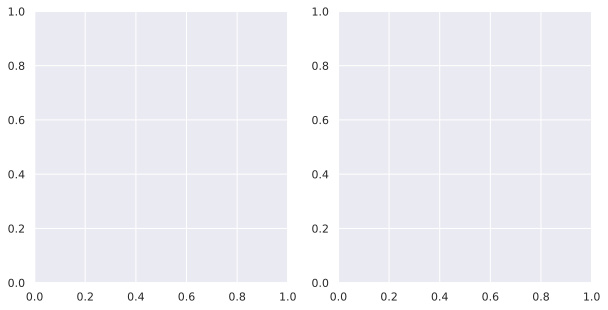

In [6]:
# normalized start and moment duration
f, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = sns.distplot(df['start (sec)']/df['length'], ax=axes[0])
axes[0].set_title('start point')
_ = sns.distplot((df['end (sec)'] - df['start (sec)'])/df['length'], ax=axes[1])
axes[1].set_title('moment duration')



In [7]:
df['start (norm)'] = df['start (sec)']/df['length']
df['end (norm)'] = df['end (sec)']/df['length']
df['moment duration (norm)'] = df['end (norm)'] - df['start (norm)']



NameError: name 'df' is not defined

NameError: name 'df' is not defined

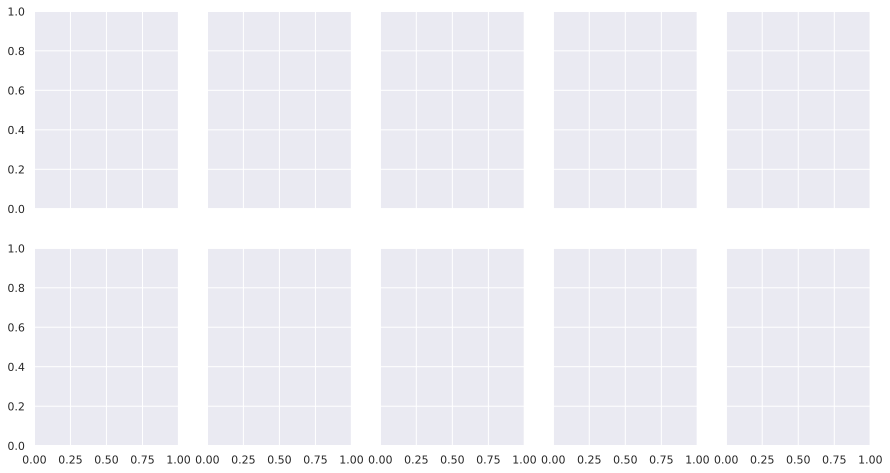

In [8]:
# distribution of moment duration for different start time

f, axes = plt.subplots(2, 5, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.ravel()
for i in range(10):
    sub_df = df[(df['start (norm)'] >= i/10) & (df['start (norm)'] < i/10 + .1)]
    sns.distplot(sub_df['moment duration (norm)'], ax=axes[i])
    axes[i].set_title('start time: %.1f-%.1f' % (i/10, i/10+.1))



NameError: name 'df' is not defined

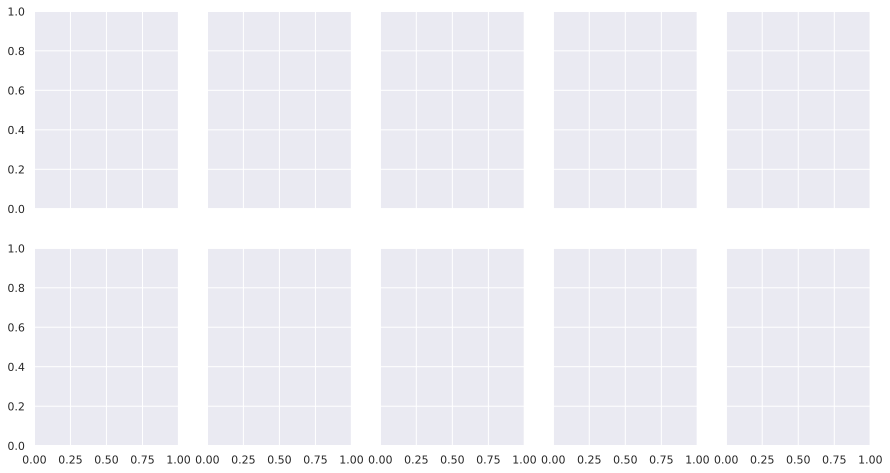

In [9]:
f, axes = plt.subplots(2, 5, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.ravel()
for i in range(10):
    sub_df = df[(df['start (norm)'] >= i/10) & (df['start (norm)'] < i/10 + .1)]
    sns.distplot(sub_df['start (norm)'], ax=axes[i])
    axes[i].set_title('%.1f ~ %.1f' % (i/10, i/10+.1))


 # Candidate moment proposal

 適当にmomentを10クラスから生成されることにして

 start time "s"とduration "d"のモデルを以下のように考える

  p(s, d) = p(s|c)p(d|c)p(c)

 それぞれの確率密度関数をgaussian mixture（component=2）として

 training setから求めてサンプルの生成に使う

 **p(d|s)を直接出した方がいいと思うけどやり方がわからない**

In [10]:


class SegmentGenerator(object):
    def __init__(self):
        self.s_dist = []
        self.d_dist = []
        self.class_dist = []

    def fit(self, df):
        for i in range(10):
            sub_df = df[(df['start (norm)'] >= i/10) & (df['start (norm)'] < i/10 + .1)]

            s_dist = GaussianMixture(2).fit(sub_df['start (norm)'].values.reshape(-1, 1))
            d_dist = GaussianMixture(2).fit(sub_df['moment duration (norm)'].values.reshape(-1, 1))

            self.s_dist.append(s_dist)
            self.d_dist.append(d_dist)
            self.class_dist.append(len(sub_df))

        self.class_dist = np.asarray(self.class_dist)/len(df)

    def sample(self, n):
        samples = []
        class_counts = np.random.multinomial(n, self.class_dist)
        classes = []
        for i, cc in enumerate(class_counts):
            classes += [i]*cc
        classes = np.random.permutation(classes)

        for c in classes:

            is_valid = False

            while(not is_valid):
                start, _ = self.s_dist[c].sample(1)
                start = start[0, 0]
                start = np.clip(start, 0, 1)

                duration, _ = self.d_dist[c].sample(1)
                duration = duration[0, 0]
                duration = np.clip(duration, 0, 1 - start)
                # if start < 0.:
                #     start = 0.
                # if start > 1.:
                #     start = 1.
                # if start + duration > 1.:
                #     duration = 1 - start
                is_valid = duration > 0

            samples.append((start, duration))

        return samples



In [11]:
sg = SegmentGenerator()
sg.fit(df)



NameError: name 'df' is not defined

In [12]:
samples = sg.sample(5000)
samples = np.asarray(samples)



ValueError: sum(pvals[:-1]) > 1.0

NameError: name 'samples' is not defined

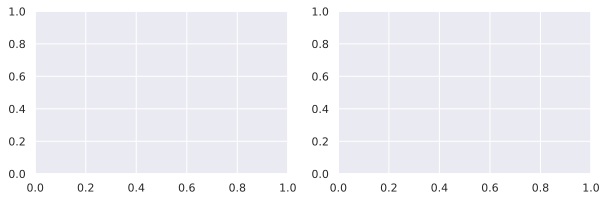

In [13]:
f, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.distplot(samples[:, 0], bins=30, ax=axes[0])
axes[0].set_title("start time (sampled)")

sns.distplot(samples[:, 1], bins=30, ax=axes[1])
axes[1].set_title("moment duration (sampled)")


 だいたいtraining setの分布をmimicできてるっぽい

 # Baseline by random segment sampling

In [14]:


def iou(pred_s, pred_e, true_s, true_e):
    assert pred_s < pred_e, "predicted value invalid"
    assert true_s < true_e, "true value invalid"

    union = min(pred_s, true_s), max(pred_e, true_e)
    intersection = max(pred_s, true_s), min(pred_e, true_e)

    if intersection[0] > intersection[1]:
        return 0

    iou_val = (intersection[1] - intersection[0]) / (union[1] - union[0])
    return iou_val



In [15]:
test_df = pd.read_csv('data/processed/test.csv')
test_df.head()



FileNotFoundError: [Errno 2] File b'data/processed/test.csv' does not exist: b'data/processed/test.csv'

In [16]:
pred = sg.sample(len(test_df)*5)
pred = np.asarray(pred)
pred[:, 1] = pred[:, 0] + pred[:, 1]  # convert (start, duration) -> (start, end)
pred = pred.reshape(-1, 10)
pred *= test_df['length'].values.reshape(-1, 1)



NameError: name 'test_df' is not defined

In [17]:
top_1 = pred[:, :2]
gt = test_df[['start (sec)', 'end (sec)']].values
res = []
for p_item, gt_item in zip(top_1, gt):
    iou_val = iou(p_item[0], p_item[1], gt_item[0], gt_item[1])
    res.append(iou_val)

print("R@1 IoU>.5: %.2f" % ((np.asarray(res) > 0.5).mean()*100))
print("R@1 IoU>.7: %.2f" % ((np.asarray(res) > 0.7).mean()*100))



NameError: name 'pred' is not defined

In [18]:
gt = test_df[['start (sec)', 'end (sec)']].values
res = []
for p_item, gt_item in zip(pred, gt):
    iou_val = max([iou(p_item[j*2], p_item[j*2+1], gt_item[0], gt_item[1]) for j in range(5)])
    res.append(iou_val)

print("R@5 IoU>.5: %.2f" % ((np.asarray(res) > 0.5).mean()*100))
print("R@5 IoU>.7: %.2f" % ((np.asarray(res) > 0.7).mean()*100))



NameError: name 'test_df' is not defined

In [19]:
# show example
i = np.random.randint(len(test_df))
true_s, true_e = gt[i]
l = test_df['length'][i]
plt.figure(figsize=(10, 2))
plt.axhline(0.1, true_s/l, true_e/l, color='m')
plt.xlim((0, 1))
plt.ylim((0, .75))

p_item = pred[i]
p_item = p_item.reshape(-1, 2)
offset = 0.2
iou_val = []
lines = []
for pred_s, pred_e in p_item:
    line = plt.axhline(offset, pred_s/l, pred_e/l, color='b')
    offset += 0.1
    iou_val.append(iou(pred_s, pred_e, true_s, true_e))
    lines.append(line)
print('max iou: %.1f' % max(iou_val))
if max(iou_val) > 0:
    lines[np.argmax(iou_val)].set_color('r')


NameError: name 'test_df' is not defined

 # ベースラインについて

 ## Random (sliding window)

 従来研究のRandomベースライン

 multi-scale temporal sliding window: {64, 128, 256, 512} frames and 80% overlap

 生成されたtemporal widowをランダムに選んだベースライン

 ## Random (moment distribution-aware)

 segmentのstart timeとdurationをtraining setのdistributionにしたがって生成するベースライン


 ## 結果

 | method                             | R@1 IoU=0.5 | R@1 IoU=0.7 | R@5 IoU=0.5 | R@5 IoU=0.7 |
 |------------------------------------|------------:|------------:|------------:|------------:|
 | Random (sliding window)            |        8.51 |        3.03 |       37.12 |       14.06 |
 | Random (moment distribution-aware) |       18.82 |        7.47 |       58.98 |       29.30 |
 | CTRL (ICCV'17)                     |       21.42 |        7.15 |       59.11 |       26.91 |
 | MAN (CVPR'19)                      |       46.53 |       22.72 |       86.23 |       53.72 |

 CTRL (Tall: Temporal activity localization via language query, ICCV'17)はRandom (moment distribution-aware)とそんなに変わらない

 ただし、ベースラインはrandomなので多少スコアは上下する

 Tall論文ではもっと単純なRandomベースラインと比較してたけどあまり意味のないベースラインかも（弱すぎベースライン）

 データにバイアスがあるのでちょっとprior入れてやるだけで割とスコアは上がる

 ## メモ

 Tallはsliding windowベースの手法。多分そこがスコアのボトルネック

 candidate proposalの生成は少なくともデータセットの分布が反映される方法でやった方がいい（学習ベースの手法）

 queryの中の特定のphrase (eg., first time, after) を考慮するだけで結構スコア上がるのでは？